  
# Water Depth Estimation using Remote Sensing and DEM
## HAND method
 
**Author:** Jin Teng (jin.teng@csiro.au)

**Compatability:** Notebook currently compatible with the NCI.

**Special requirements:** This notebook requires the pysheds package. At the moment, this is not part of the standard NCI environment. To install this in your own user environment, open a new terminal window, change to the directory you want to download it into and type the following commands:

    $ git clone https://github.com/mdbartos/pysheds 
$ cd pysheds
    $ pip install .

    
You will only need to install this package once. You'll know that this has happened because when you try to run the Load Packages cell below, you will get an error saying that pysheds cannot be found.

**Dependencies:** The code below requires installation of following packages:

    rasterio
    numpy
    scipy
    pysheds


## Description

This is a simplistic tool that estimate water depth from satellite imagery and DEM. It is developed to add value to remote sensing (RS) analysis by calculating water depth based solely on an inundation map with an associated digital elevation model (DEM).

The main steps of the algorithm are:

    (1) normalise DEM by calculating HAND;
    (2) extract the polygons for the inundation extent from the raster; 
    (3) extract the HAND value for these polygons;
    (4) calculate the maximum HAND value for each and all polygons;
    (5) calculate floodwater depth by subtracting HAND value for each cell from the maximum HAND value.

We have included a run-down of the tool that is demonstrated in the notebook. 

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

## Load packages

Import Python packages that are used for the analysis.

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import time
import rasterio
import numpy as np
from scipy import ndimage
from pysheds.grid import Grid

## Set input variables

In [20]:
FloodExtent_tif = os.path.join('data', 'FloodExtent_modified.tif')
DEM_tif = os.path.join('data', 'Elevation.tif')
output_path = os.path.join('data','output_wd_HAND_all.tif')
accumulation_threshold = 1000
WOfS_nodata_value = 0
WOfS_dry_value = 2
WOfS_wet_value = 3

## Read DEM

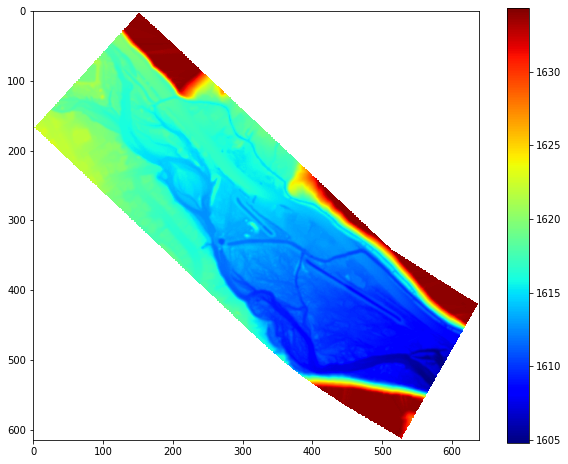

In [8]:
with rasterio.open(DEM_tif) as src_dem:
    dem = src_dem.read(1, masked = True)
plt.figure(figsize=(10,8))
plt.imshow(dem,cmap='jet')
plt.colorbar()
grid = Grid()
grid.read_raster(DEM_tif, data_name='dem')

## Calculating HAND
This cell is adapted from https://github.com/GeoscienceAustralia/dea-notebooks/blob/ClaireK/Scientific_workflows/DEAWetlands/WetlandWaterDepthAnalyses.ipynb written by Claire Krause.

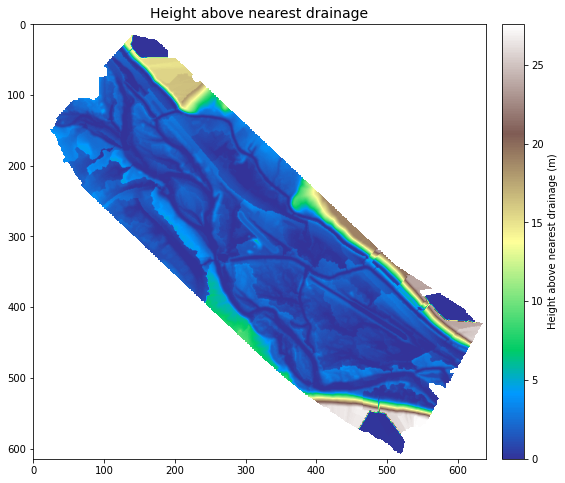

In [30]:
# Fill dead end depressions
grid.fill_depressions(data='dem', out_name='nopits_dem')
# Inflate the DEM to resolve the drainage network over flat terrain
grid.resolve_flats(data='nopits_dem', out_name='inflated_dem')
# Calculate flow direction
grid.flowdir(data='inflated_dem', out_name='dir')
# Compute flow accumulation based on computed flow direction
grid.accumulation(data='dir', out_name='acc')
# Compute HAND
grid.compute_hand('dir', 'inflated_dem', grid.acc > accumulation_threshold, 'hand')
# Plot
fig, ax = plt.subplots(figsize=(10,8))
im = plt.imshow(grid.hand, zorder=1, cmap='terrain', interpolation='bilinear')
plt.colorbar(im, fraction=0.044, pad=0.03, label='Height above nearest drainage (m)');
plt.title('Height above nearest drainage', size=14);

## Read flood extent raster

--- 0.008977413177490234 seconds ---


Text(0.5, 1.0, 'Flood Extent map')

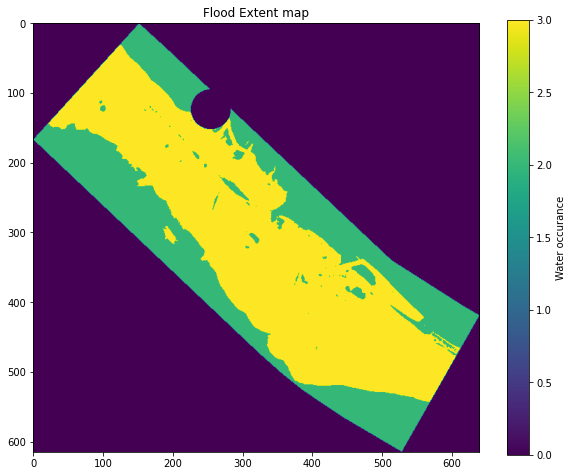

In [21]:
start_time = time.time()
with rasterio.open(FloodExtent_tif) as src:
    flood_extent = src.read(1)
out_mask = flood_extent!=WOfS_wet_value
wet = np.where(flood_extent==WOfS_wet_value,1,0)
print("--- %s seconds ---" % (time.time() - start_time))
plt.figure(figsize=(10,8))
plt.imshow(flood_extent)
plt.colorbar(label='Water occurance')
plt.title('Flood Extent map')

## Group the flood extent into polygons

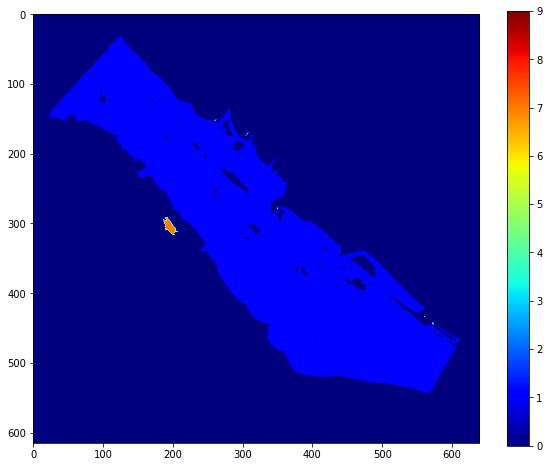

In [22]:
structure = np.ones((3, 3))
groups, num_ids = ndimage.label(wet, structure=structure)
group_ids = np.arange(0, num_ids + 1)
plt.figure(figsize=(10,8))
plt.imshow(groups,cmap='jet')
plt.colorbar()

## Calculating water depth using all and individual polygon

Text(0.5, 1.0, 'Individual')

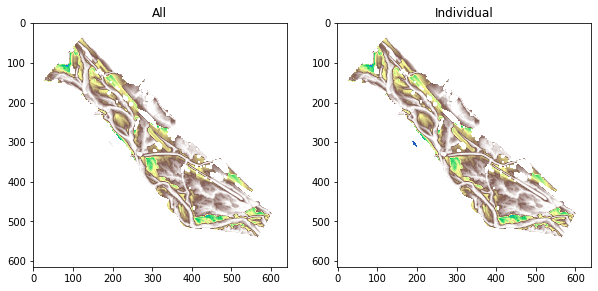

In [42]:
dem = grid.hand
dem[np.isnan(dem)] = 0
# All
max = np.max(wet * dem)
water_depth_a = max - dem
water_depth_a[water_depth_a<0] = 0
water_depth_a =np.ma.masked_where(out_mask, water_depth_a)
# Individual
groups_max = ndimage.maximum(dem, groups, group_ids) 
water_depth_i = np.array([groups_max[x] for x in groups]) - dem
water_depth_i[water_depth_i<0] = 0
water_depth_i =np.ma.masked_where(out_mask, water_depth_i)
plt.figure(figsize=(10,8))
plt.subplot(121)
plt.imshow(water_depth_a,cmap='terrain')
plt.title('All')
plt.subplot(122)
plt.imshow(water_depth_i,cmap='terrain')
plt.title('Individual')

## Write output

In [43]:
waterdepth_path = os.path.join(os.path.dirname(output_path), 'output_wd_hand_all.tif')
with rasterio.open(
    waterdepth_path, 'w',
    driver='GTiff',
    dtype=water_depth_a.dtype,
    count=1,
    nodata=np.nan,
    transform = src_dem.transform,
    width=src_dem.width,
    height=src_dem.height) as dst:
    dst.write(water_depth_a, indexes=1)
waterdepth_path = os.path.join(os.path.dirname(output_path), 'output_wd_hand_individual.tif')
with rasterio.open(
    waterdepth_path, 'w',
    driver='GTiff',
    dtype=water_depth_i.dtype,
    count=1,
    nodata=np.nan,
    transform = src_dem.transform,
    width=src_dem.width,
    height=src_dem.height) as dst:
    dst.write(water_depth_i, indexes=1)